# Pre Earnings Analysis

TODO

Conclusions:

* TBD

## Data and Methodology


In [1]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimizeConsensusService, EventStudyService,
    FactorService, MarketCapService, ResidualReturnsService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
calendar_service = injector.get(CalendarService)
asset_service = injector.get(AssetService)
asset_info_service = injector.get(AssetInfoService)
estimize_consensus_service = injector.get(EstimizeConsensusService)
market_cap_service = injector.get(MarketCapService)
factor_service = injector.get(FactorService)


In [2]:
def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def fix_row_index(row):
    index = row[0]
    cols = row[1]
    date = index[0]
    asset = index[1]

    if cols['bmo']:
        date = date - timedelta(days=1)

    date = calendar_service.get_valid_trading_end_date(date)

    return date, asset

def fix_index(df):
    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def shift_index(df, days):
    def shift_row_index(row):
        index = row[0]
        cols = row[1]
        date = index[0]
        asset = index[1]

        date = date + timedelta(days=days)
        date = calendar_service.get_valid_trading_end_date(date)

        return date, asset

    df.index = pd.MultiIndex.from_tuples(list(map(shift_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def get_final_consensuses(start_date, end_date):
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    fix_index(df)
    
    return df

def get_consensuses(start_date, end_date):
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    fix_index(df)
    
    df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(-5)), 'as_of_date')
    
    cdf = estimize_consensus_service.get_consensuses(start_date, end_date)[['estimize.eps.weighted', 'estimize.eps.sd']]
    cdf.rename(columns={'estimize.eps.weighted': 'estimize.eps.weighted-5', 'estimize.eps.sd': 'estimize.eps.sd-5'}, inplace=True)
    
    df = df.join(cdf, how='inner')
    df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(5)), 'as_of_date')
    
    return df

def get_asset_returns(start_date, end_date, assets):
    df = asset_service.get_returns(start_date, end_date, assets)[['intra_day_return', 'inter_day_return']]

    return df

def get_benchmark_returns(start_date, end_date):
    spy = asset_service.get_asset('SPY')
    df = asset_service.get_returns(start_date, end_date, [spy])[['intra_day_return', 'inter_day_return']]
    df.reset_index(inplace=True)
    df.set_index(['as_of_date'], inplace=True)
    df.drop(['asset'], axis=1, inplace=True)
    df.rename(columns={
        'intra_day_return': 'benchmark_intra_day_return',
        'inter_day_return': 'benchmark_inter_day_return'
    }, inplace=True)

    return df

def shift_date_fn(days):
    if days > 0:
        index = -1
    else:
        index = 0
    
    def shift_date(date):
        if days != 0:
            return calendar_service.get_n_trading_days_from(days, date)[index]
        else:
            return date
    
    return shift_date    

def get_residual_returns(eps_deltas):
    df = eps_deltas
    
    df.reset_index(inplace=True)
    df['estimation_as_of_date'] = df['as_of_date'].map(shift_date_fn(-5))
    df.rename(columns={'as_of_date': 'original_as_of_date'}, inplace=True)
    df.rename(columns={'estimation_as_of_date': 'as_of_date'}, inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    start_date = df.index.get_level_values('as_of_date').min() - timedelta(days=7)
    end_date = df.index.get_level_values('as_of_date').max() + timedelta(days=7)
    assets = dfutils.unique_assets(df)
    fdf = factor_service.get_market_factors(start_date, end_date, assets)
    
    df = df.join(fdf, how='inner')
    df.reset_index(inplace=True)
    df.drop('as_of_date', axis=1, inplace=True)
    df.rename(columns={'original_as_of_date': 'as_of_date'}, inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    ardf = get_asset_returns(start_date, end_date, assets)
    brdf = get_benchmark_returns(start_date, end_date)
    
    for i in [-5, -4, -3, -2, -1, 0, 1]:
        df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(i)), 'as_of_date')
        
        df = df.join(ardf, how='inner')
        df.reset_index(inplace=True)
        df.set_index('as_of_date', inplace=True)

        df = df.join(brdf, how='inner')
        df.reset_index(inplace=True)
        df.set_index(['as_of_date', 'asset'], inplace=True)

        df['inter_day_residual_return_{}'.format(i)] = df['inter_day_return'] - (df['alpha'] + (df['beta'] * df['benchmark_inter_day_return']))
        df['intra_day_residual_return_{}'.format(i)] = df['intra_day_return'] - (df['alpha'] + (df['beta'] * df['benchmark_intra_day_return']))
        df.drop(['inter_day_return', 'intra_day_return', 'benchmark_inter_day_return', 'benchmark_intra_day_return'], axis=1, inplace=True)
        
        df.index = df.index.set_levels(df.index.levels[0].map(shift_date_fn(-i)), 'as_of_date')
    
    df.drop(['alpha', 'beta'], axis=1, inplace=True)
    
    return df
    
def get_observations(start_date, end_date):
    aidf = asset_info_service.get_asset_info()
    
    df = get_consensuses(start_date, end_date)
    df.reset_index(inplace=True)
    df.set_index('asset', inplace=True)
    df = df.join(aidf, how='inner')
    df.reset_index(inplace=True)
    df.set_index(['as_of_date', 'asset'], inplace=True)
    
    df = get_residual_returns(df)
    
    assets = dfutils.unique_assets(df)
    mcdf = market_cap_service.get_market_caps(start_date, end_date, assets)
    df = df.join(mcdf, how='inner')
    
    print(df.head())
    
    return df

def normalize_values(values):
    return 2 * (values - values.min()) / (values.max() - values.min())  - 1


In [3]:
# Run all-time event study with wallstreet estimates

start_date = '2012-01-01'
end_date = '2017-10-01'

df = get_observations(start_date, end_date)

                                fiscal_year  fiscal_quarter reports_at_date  \
as_of_date asset                                                              
2012-01-31 Equity(2730 [AMZN])         2011               4      2012-01-31   
2012-02-01 Equity(2795 [CMG])          2011               4      2012-02-01   
           Equity(2796 [CMI])          2011               4      2012-02-02   
2012-02-08 Equity(2810 [CSCO])         2012               2      2012-02-08   
           Equity(3168 [WFM])          2012               1      2012-02-08   

                                  bmo  estimize.eps.weighted  \
as_of_date asset                                               
2012-01-31 Equity(2730 [AMZN])  False               0.230810   
2012-02-01 Equity(2795 [CMG])   False               1.871884   
           Equity(2796 [CMI])    True               2.348370   
2012-02-08 Equity(2810 [CSCO])  False               0.453300   
           Equity(3168 [WFM])   False               0.319187  

len:  23660
['inter_day_residual_return_-5', 'intra_day_residual_return_-5', 'inter_day_residual_return_-4', 'intra_day_residual_return_-4', 'inter_day_residual_return_-3', 'intra_day_residual_return_-3', 'inter_day_residual_return_-2', 'intra_day_residual_return_-2', 'inter_day_residual_return_-1', 'intra_day_residual_return_-1', 'inter_day_residual_return_0', 'intra_day_residual_return_0']
len post NAN filter:  23203
len post calc filter:  23203
23203
-57.62185796700459
0.03844918488294275
81.44167350410257
1.425865147869747
19291
ea_eps_delta ~ ['ew_eps_delta', 'es_eps_delta']
                            OLS Regression Results                            
Dep. Variable:           ea_eps_delta   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.016
Method:                 Least Squares   F-statistic:                     162.6
Date:                Tue, 13 Mar 2018   Prob (F-statistic):           9.25e-71
Time:             

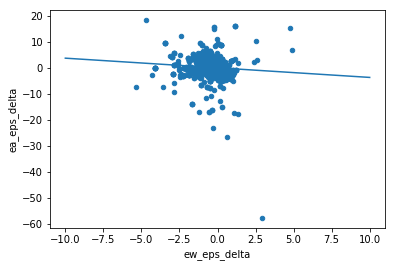

In [270]:
import sklearn.neural_network as nn
from sklearn.preprocessing import StandardScaler  
scaler = StandardScaler()

rdf = df.reset_index()
print('len: ', len(rdf))

residual_returns_cols = []
for i in [-5, -4, -3, -2, -1, 0, 1]:
    residual_returns_cols += ['inter_day_residual_return_{}'.format(i), 'intra_day_residual_return_{}'.format(i)]
    
pre_report_returns_cols = residual_returns_cols[0:-2]
print(pre_report_returns_cols)

other_columns = ['asset', 'actual.eps', 'estimize.eps.mean',
                 'estimize.eps.weighted-5', 'estimize.eps.sd-5', 
                 'estimize.eps.weighted', 'estimize.eps.sd', 
                 'estimize.eps.count', 'wallstreet.eps', 'market_cap', 'sector'
                ]

rdf = rdf[other_columns + residual_returns_cols]
rdf.dropna(inplace=True)
print('len post NAN filter: ', len(rdf))

rdf['caar_pre'] = rdf[pre_report_returns_cols].sum(axis=1)
rdf['ea_eps_diff'] = rdf['actual.eps'] - rdf['estimize.eps.weighted']
# rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['h_eps_delta'] = (rdf['estimize.eps.weighted'] - rdf['estimize.eps.weighted-5']) / (rdf['estimize.eps.sd-5'] + 0.01)

rdf['ew_eps_diff'] = rdf['wallstreet.eps'] - rdf['estimize.eps.weighted']
# rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['es_eps_diff'] = rdf['estimize.eps.weighted'] - rdf['estimize.eps.mean']
# rdf['es_eps_delta'] = rdf['es_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['es_eps_delta'] = rdf['es_eps_diff'] / (np.abs(rdf['estimize.eps.mean']) + 0.01)

rdf.dropna(inplace=True)
print('len post calc filter: ', len(rdf))

print(len(rdf))
print(rdf.ea_eps_delta.min())
print(rdf.ea_eps_delta.mean())
print(rdf.ea_eps_delta.max())
print(rdf.ea_eps_delta.std())

# rdf['ea_eps_delta'] = stats.mstats.winsorize(rdf['ea_eps_delta'], limits=[0.05, 0.05])
# rdf['ew_eps_delta'] = stats.mstats.winsorize(rdf['ew_eps_delta'], limits=[0.05, 0.05])
# rdf['es_eps_delta'] = stats.mstats.winsorize(rdf['es_eps_delta'], limits=[0.05, 0.05])

def expanding_z_score(values):
    mean = values.expanding().mean()
    std = values.expanding().std()
    values = (values - mean) / (std + 0.01)
    values.fillna(0.0, inplace=True)
    return values

# rdf['ew_eps_delta_z'] = rdf.groupby('asset')['ew_eps_diff'].transform(expanding_z_score)
# rdf['ew_eps_delta_z'] = stats.mstats.winsorize(rdf.ew_eps_delta_z, limits=[0.05, 0.05])

# rdf['es_eps_delta_z'] = rdf.groupby('asset')['es_eps_diff'].transform(expanding_z_score)
# rdf['es_eps_delta_z'] = stats.mstats.winsorize(rdf.es_eps_delta_z, limits=[0.05, 0.05])

# rdf['ea_eps_delta_z'] = rdf.groupby('asset')['ea_eps_diff'].transform(expanding_z_score)
# rdf['ea_eps_delta_z'] = stats.mstats.winsorize(rdf.ea_eps_delta_z, limits=[0.05, 0.05])

rdf = rdf[rdf['estimize.eps.count'] >= 10]
rdf = rdf[np.abs(rdf.ew_eps_delta) < 8]
# print('len post filter: ', len(rdf))

# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap']  # R2 = 2.1%
# model_columns = ['caar_pre', 'ew_eps_delta_z', 'es_eps_delta_z', 'h_eps_delta', 'market_cap']  # R2 = 3.1%
# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap'] + sector_columns  # R2 = 2.1%
# model_columns = ['ew_eps_delta', 'es_eps_delta']  # R2 = 0.5%
# model_columns = ['caar_pre', 'ew_eps_delta', 'es_eps_delta', 'h_eps_delta']  # R2 = 1.6%
model_columns = ['ew_eps_delta', 'es_eps_delta']  # R2 = 16.7%

# value_column = 'ea_eps_delta_z'
# value_column = 'inter_day_residual_return_1'
value_column = 'ea_eps_delta'

rdf = rdf[[value_column] + model_columns]
rdf.dropna(inplace=True)
print(len(rdf))

print('{} ~ {}'.format(value_column, model_columns))

X = rdf[model_columns]
X = sm.add_constant(X)
y = rdf[value_column]

model = sm.OLS(y, X).fit()

# Print out the statistics
print(model.summary())

p = model.params

# generate x-values for your regression line (two is sufficient)
x = np.arange(-10, 11)

# scatter-plot data
ax = rdf.plot(x=model_columns[0], y=value_column, kind='scatter')
ax.plot(x, p.const + p[model_columns[0]] * x)
# ax.set_xlim([-3, 0.01])

In [13]:
import sklearn.neural_network as nn
from sklearn.preprocessing import StandardScaler, MinMaxScaler

rdf = df.reset_index()
print('len: ', len(rdf))

residual_returns_cols = []
for i in [-5, -4, -3, -2, -1, 0, 1]:
    residual_returns_cols += ['inter_day_residual_return_{}'.format(i), 'intra_day_residual_return_{}'.format(i)]
    
pre_report_returns_cols = residual_returns_cols[0:-2]
print(pre_report_returns_cols)

other_columns = ['asset', 'actual.eps', 'estimize.eps.mean',
                 'estimize.eps.weighted-5', 'estimize.eps.sd-5', 
                 'estimize.eps.weighted', 'estimize.eps.sd', 
                 'estimize.eps.count', 'wallstreet.eps', 'market_cap', 'sector'
                ]

rdf = rdf[other_columns + residual_returns_cols]
rdf.dropna(inplace=True)
print('len post NAN filter: ', len(rdf))

rdf['caar_pre'] = rdf[pre_report_returns_cols].sum(axis=1)
rdf['ea_eps_diff'] = rdf['actual.eps'] - rdf['estimize.eps.weighted']
# rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['h_eps_delta'] = (rdf['estimize.eps.weighted'] - rdf['estimize.eps.weighted-5']) / (rdf['estimize.eps.sd-5'] + 0.01)

rdf['ew_eps_diff'] = rdf['wallstreet.eps'] - rdf['estimize.eps.weighted']
# rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['es_eps_diff'] = rdf['estimize.eps.weighted'] - rdf['estimize.eps.mean']
# rdf['es_eps_delta'] = rdf['es_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['es_eps_delta'] = rdf['es_eps_diff'] / (np.abs(rdf['estimize.eps.mean']) + 0.01)

rdf.dropna(inplace=True)

print(len(rdf))
print(rdf.ea_eps_delta.min())
print(rdf.ea_eps_delta.mean())
print(rdf.ea_eps_delta.max())
print(rdf.ea_eps_delta.std())

rdf['ea_eps_delta'] = stats.mstats.winsorize(rdf['ea_eps_delta'], limits=[0.05, 0.05])
rdf['ew_eps_delta'] = stats.mstats.winsorize(rdf['ew_eps_delta'], limits=[0.05, 0.05])
rdf['es_eps_delta'] = stats.mstats.winsorize(rdf['es_eps_delta'], limits=[0.05, 0.05])

# rdf['count'] = rdf.groupby('asset').size()
# rdf = rdf[rdf['count'] > 3]
# print('len post count filter:', len(rdf))

def expanding_z_score(values):
    mean = values.expanding().mean()
    std = values.expanding().std()
    return (values - mean) / std

rdf['ew_eps_delta_z'] = rdf.groupby('asset')['ew_eps_delta'].transform(expanding_z_score)
rdf.ew_eps_delta_z.fillna(0.0, inplace=True)

rdf['es_eps_delta_z'] = rdf.groupby('asset')['es_eps_delta'].transform(expanding_z_score)
rdf.es_eps_delta_z.fillna(0.0, inplace=True)

rdf['ea_eps_delta_z'] = rdf.groupby('asset')['ea_eps_delta'].transform(expanding_z_score)
rdf.ea_eps_delta_z.fillna(0.0, inplace=True)

sectors = rdf.sector.unique()
sector_columns = []
for i, s in enumerate(sectors):
    col = 'sector_{}'.format(i)
    rdf[col] = (rdf.sector == s)
    sector_columns.append(col)

# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap']  # R2 = 1.6%
# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap'] + sector_columns  # R2 = 2.8%
model_columns = ['ew_eps_delta', 'es_eps_delta', 'market_cap']  # R2 = ?
# model_columns = ['ea_eps_delta']  # R2 = ?

# value_column = 'ea_eps_delta_z'
value_column = 'inter_day_residual_return_1'
# value_column = 'ea_eps_delta'

rdf = rdf[[value_column] + model_columns]
rdf.dropna(inplace=True)
print(len(rdf))

print('{} ~ {}'.format(value_column, model_columns))

train, test = np.split(rdf.sample(frac=1), [int(.8*len(rdf))])
print('train: ', len(train))
print('test: ', len(test))

scaler = MinMaxScaler(feature_range=(-1,1))
y_scaler = MinMaxScaler(feature_range=(-1,1))

X_train = train[model_columns]
scaler.fit(X_train)
X_train = scaler.transform(X_train)

y_train = train[value_column]
y_scaler.fit(y_train.reshape(-1, 1))
y_train = y_scaler.transform(y_train.reshape(-1, 1))

model = nn.MLPRegressor(
    hidden_layer_sizes=(2,),
    activation='tanh',
    solver='lbfgs',
    max_iter=400,
    verbose=True
)

results = model.fit(X_train, y_train)

score_train = results.score(X_train, y_train)
print('train score: ', score_train)

# Test
X_test = test[model_columns]
X_test = scaler.transform(X_test)
# 
y_test = test[value_column]
y_test = y_scaler.transform(y_test.reshape(-1, 1))

score_test = results.score(X_test, y_test)
print('test score: ', score_test)
pred_test = results.predict(X_test)
# dft = pd.DataFrame({'actual': y_test.reshape(-1, -1), 'pred': pred_test})
# display(dft)



len:  23660
['inter_day_residual_return_-5', 'intra_day_residual_return_-5', 'inter_day_residual_return_-4', 'intra_day_residual_return_-4', 'inter_day_residual_return_-3', 'intra_day_residual_return_-3', 'inter_day_residual_return_-2', 'intra_day_residual_return_-2', 'inter_day_residual_return_-1', 'intra_day_residual_return_-1', 'inter_day_residual_return_0', 'intra_day_residual_return_0']
len post NAN filter:  23203
23203
-57.62185796700459
0.03844918488294275
81.44167350410257
1.425865147869747
23203
inter_day_residual_return_1 ~ ['ew_eps_delta', 'es_eps_delta', 'market_cap']
train:  18562
test:  4641
train score:  -0.0011001153824736765
test score:  -0.001325614760572913


In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.datasets import make_multilabel_classification
from sklearn.preprocessing import LabelBinarizer, StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import CCA

scaler = StandardScaler()

rdf = df.reset_index()
print('len: ', len(rdf))

residual_returns_cols = []
for i in [-5, -4, -3, -2, -1, 0, 1]:
    residual_returns_cols += ['inter_day_residual_return_{}'.format(i), 'intra_day_residual_return_{}'.format(i)]
    
pre_report_returns_cols = residual_returns_cols[0:-2]
print(pre_report_returns_cols)

other_columns = ['asset', 'actual.eps', 'estimize.eps.mean',
                 'estimize.eps.weighted-5', 'estimize.eps.sd-5', 
                 'estimize.eps.weighted', 'estimize.eps.sd', 
                 'estimize.eps.count', 'wallstreet.eps', 'market_cap', 'sector'
                ]

rdf = rdf[other_columns + residual_returns_cols]
rdf.dropna(inplace=True)
print('len post NAN filter: ', len(rdf))

rdf['caar_pre'] = rdf[pre_report_returns_cols].sum(axis=1)
rdf['ea_eps_diff'] = rdf['actual.eps'] - rdf['estimize.eps.weighted']
# rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ea_eps_delta'] = rdf['ea_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['h_eps_delta'] = (rdf['estimize.eps.weighted'] - rdf['estimize.eps.weighted-5']) / (rdf['estimize.eps.sd-5'] + 0.01)

rdf['ew_eps_diff'] = rdf['wallstreet.eps'] - rdf['estimize.eps.weighted']
# rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['ew_eps_delta'] = rdf['ew_eps_diff'] / (np.abs(rdf['estimize.eps.weighted']) + 0.01)

rdf['es_eps_diff'] = rdf['estimize.eps.weighted'] - rdf['estimize.eps.mean']
# rdf['es_eps_delta'] = rdf['es_eps_diff'] / (rdf['estimize.eps.sd'] + 0.01)
rdf['es_eps_delta'] = rdf['es_eps_diff'] / (np.abs(rdf['estimize.eps.mean']) + 0.01)

rdf.dropna(inplace=True)

print(len(rdf))
print(rdf.ea_eps_delta.min())
print(rdf.ea_eps_delta.mean())
print(rdf.ea_eps_delta.max())
print(rdf.ea_eps_delta.std())

# rdf['ea_eps_delta'] = stats.mstats.winsorize(rdf['ea_eps_delta'], limits=[0.05, 0.05])
# rdf['ew_eps_delta'] = stats.mstats.winsorize(rdf['ew_eps_delta'], limits=[0.05, 0.05])
# rdf['es_eps_delta'] = stats.mstats.winsorize(rdf['es_eps_delta'], limits=[0.05, 0.05])

def expanding_z_score(values):
    mean = values.expanding().mean()
    std = values.expanding().std()
    return (values - mean) / std

rdf['ew_eps_delta_z'] = rdf.groupby('asset')['ew_eps_delta'].transform(expanding_z_score)
rdf.ew_eps_delta_z.fillna(0.0, inplace=True)

rdf['es_eps_delta_z'] = rdf.groupby('asset')['es_eps_delta'].transform(expanding_z_score)
rdf.es_eps_delta_z.fillna(0.0, inplace=True)

rdf['ea_eps_delta_z'] = rdf.groupby('asset')['ea_eps_delta'].transform(expanding_z_score)
rdf.ea_eps_delta_z.fillna(0.0, inplace=True)

sectors = rdf.sector.unique()
sector_columns = []
for i, s in enumerate(sectors):
    col = 'sector_{}'.format(i)
    rdf[col] = (rdf.sector == s)
    sector_columns.append(col)

# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap']  # R2 = 1.6%
# model_columns = ['ew_eps_delta_z', 'es_eps_delta_z', 'market_cap'] + sector_columns  # R2 = 2.8%
model_columns = ['ew_eps_delta', 'es_eps_delta', 'market_cap']  # R2 = ?
# model_columns = ['ea_eps_delta']  # R2 = ?

# value_column = 'ea_eps_delta_z'
value_column = 'inter_day_residual_return_1'
# value_column = 'ea_eps_delta'

rdf = rdf[[value_column] + model_columns]
rdf.dropna(inplace=True)
print('post model length: ', len(rdf))
print('{} ~ {}'.format(value_column, model_columns))

# Convert value_column to classes
rdf[value_column] = pd.qcut(rdf[value_column].values, 3, labels=False) + 1
lb = LabelBinarizer()
lb.fit(rdf[value_column])

train, test = np.split(rdf.sample(frac=1), [int(.8*len(rdf))])
print('train: ', len(train))
print('test: ', len(test))

X_train = train[model_columns]
# scaler.fit(X_train)
# X_train = scaler.transform(X_train)
print('PCA start')
X_train = PCA(n_components=len(model_columns)).fit_transform(X_train)
print('PCA end')
y_train = lb.transform(train[value_column])

# classif = OneVsRestClassifier(SVC(
#     kernel='linear',
#     verbose=True,
# #     max_iter=2000
# ), n_jobs=-1)
# print('Classify start')
# results = classif.fit(X_train, y_train)
# print('Classify end')
# print(results)

# score_train = results.score(X_train, y_train)
# print('train score: ', score_train)

# # Test
# X_test = test[model_columns]
# X_test = scaler.transform(X_test)
# y_test = test[value_column]

# score_test = results.score(X_test, y_test)
# print('test score: ', score_test)
# pred_test = results.predict(X_test)
# dft = pd.DataFrame({'actual': y_test, 'pred': pred_test})
# display(dft)


len:  23660
['inter_day_residual_return_-5', 'intra_day_residual_return_-5', 'inter_day_residual_return_-4', 'intra_day_residual_return_-4', 'inter_day_residual_return_-3', 'intra_day_residual_return_-3', 'inter_day_residual_return_-2', 'intra_day_residual_return_-2', 'inter_day_residual_return_-1', 'intra_day_residual_return_-1', 'inter_day_residual_return_0', 'intra_day_residual_return_0']
len post NAN filter:  23203
23203
-57.62185796700459
0.03844918488294275
81.44167350410257
1.425865147869747
post model length:  23203
inter_day_residual_return_1 ~ ['ew_eps_delta', 'es_eps_delta', 'market_cap']
train:  18562
test:  4641
PCA start
PCA end
Classify start
